# Train Target Model

In [1]:
import pandas as pd
import joblib
from joblib import Parallel, delayed
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import shap
import optuna
import sglearn
from scipy import stats
from datetime import datetime
import numpy as np
import plotnine as gg
import seaborn as sns
from Bio.SeqUtils import ProtParamData
import matplotlib.pyplot as plt
import gpplot


from datasets import dataset_list, get_sg_groups_df
import target_featurization as ft

In [2]:
def lgbm_training_iteration(fold_df, train_index, features,
                            aa_seq_df, aa_features, aa_width,
                            protein_domain_df,
                            conservation_df, cons_small_width,
                            cons_large_width,
                            test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param features: list, features to us
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param test_index: list-like
    :param base_model: LGBMRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df, aa_features=aa_features,
                                                                      aa_width=aa_width,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df,
                                                                      cons_small_width=cons_small_width,
                                                                      cons_large_width=cons_large_width)
    X_train_val = train_feature_df[train_feature_cols] # train and validation data
    y_train_val = train_df['Residual Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train,
              regressor__early_stopping_rounds=20,
              regressor__eval_set=[(X_val, y_val)],
              regressor__verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df, aa_features=aa_features,
                                                                    aa_width=aa_width,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df,
                                                                    cons_small_width=cons_small_width,
                                                                    cons_large_width=cons_large_width)
    X_test = test_feature_df[test_feature_cols]
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    r2 = r2_score(test_predictions['Residual Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(train_df, features, aa_seq_df, aa_features, aa_width,
                       protein_domain_df,
                       conservation_df, cons_small_width, cons_large_width):
    """Get objective function for training a lgbm model

    :param train_df: DataFrame
    :param features: list
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('regressor',
                           LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                                         num_leaves=num_leaves,
                                         min_child_samples=min_child_samples))])
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (train_df, train_index, features,
                                          aa_seq_df, aa_features, aa_width,
                                          protein_domain_df,
                                          conservation_df,
                                          cons_small_width, cons_large_width,
                                          test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(train_df, train_df.dataset, train_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective


def lolliplop_plot(data, cat, val):
    g = (gg.ggplot(data) +
         gg.aes(y=val, ymin=0, ymax=val, x=cat, xend=cat) +
         gg.geom_point(size=4, shape='.') +
         gg.geom_linerange() +
         gg.coord_flip() +
         gg.theme_classic())
    return g

## Reading Data

In [3]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')
codon_map_df = pd.read_csv('../data/external/codon_map.csv')

### Rename Database Columns

In [4]:
aa_seqs = aa_seqs.rename({'query': 'Transcript Base'}, axis=1)
protein_domains = protein_domains.rename({'Parent': 'Transcript Base'}, axis=1)

## Loading Datasets

In [5]:
train_data_list = list()
exogenous_data_list = list()
for ds in dataset_list:
    if (ds.name in train_data_names):
        if ds.endogenous:
            train_data_list.append(ds)
        else:
            exogenous_data_list.append(ds)


sg_groups_df = get_sg_groups_df(train_data_list)
sg_groups_df = ft.add_target_columns(sg_groups_df)

Context sequences with multiple targets: 0


In [6]:
print('Number of exogenous datasets: ' + str(len(exogenous_data_list)))
exog_ds = exogenous_data_list[0]
exog_ds.load_data()
exog_df = exog_ds.get_sg_df(include_group=False, include_activity=True)
exog_df['dataset'] = exog_ds.name

Number of exogenous datasets: 1


## Read Conservation Data

In [7]:
transcript_bases = list(sg_groups_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))
conservation_df['ranked_conservation'] = (conservation_df.groupby('Transcript Base')
                                          ['conservation']
                                          .rank(pct=True))

## Calculate Residuals

In [8]:
sg_df_residuals = sg_groups_df.copy()
sg_df_residuals['sgRNA Activity'] = (sg_df_residuals.groupby('dataset')
                                     ['sgRNA Activity']
                                     .rank(pct=True))
seq_X = sglearn.featurize_guides(sg_df_residuals['sgRNA Context Sequence'])
sg_df_residuals['Rule Set 3'] = seq_model.predict(seq_X)
(sg_df_residuals.groupby('dataset')
 .apply(lambda df: stats.pearsonr(df['Rule Set 3'], df['sgRNA Activity'])))

dataset
Doench2014_human     (0.7747588150394162, 6.327280047472541e-200)
Doench2014_mouse    (0.7221909327038771, 4.8841724249361805e-189)
Doench2016                        (0.6639725734142461, 3.06e-322)
Wang2014              (0.740204397054155, 4.967999241925921e-178)
dtype: object

In [9]:
sg_df_residuals['Residual Activity'] = sg_df_residuals['sgRNA Activity'] - sg_df_residuals['Rule Set 3']

In [10]:
## Training Model

In [11]:
features = ['position', 'aa', 'domain', 'conservation'] # no nt
aa_features = ['Pos. Ind. 1mer', 'Hydrophobicity', 'Aromaticity',
               'Isoelectric Point', 'Secondary Structure']
aa_width = 8
cons_small_width=2
cons_large_width=32
n_trials = 50

In [12]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
objective = get_lgbm_objective(sg_df_residuals, features=features,
                               aa_seq_df=aa_seqs, aa_width=aa_width,
                               aa_features=aa_features, protein_domain_df=protein_domains,
                               conservation_df=conservation_df, cons_small_width=cons_small_width,
                               cons_large_width=cons_large_width)
start_time = datetime.now()
study.optimize(objective, n_trials=n_trials)
end_time = datetime.now()
difference = end_time - start_time
print("Number of finished trials: {}".format(len(study.trials)))
print("Training Time: " + str(difference))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Using optimal parameters, retrain model with full dataset
train_feature_df, train_feature_cols = ft.build_target_feature_df(sg_df_residuals,
                                                                  features=features,
                                                                  aa_seq_df=aa_seqs, aa_width=aa_width,
                                                                  aa_features=aa_features,
                                                                  protein_domain_df=protein_domains,
                                                                  conservation_df=conservation_df,
                                                                  cons_small_width=cons_small_width,
                                                                  cons_large_width=cons_large_width)
X_train_val = train_feature_df[train_feature_cols] # train and validation data
y_train_val = sg_df_residuals['Residual Activity']
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.1, random_state=7)
model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                  ('regressor', LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                   **trial.params))])
model.fit(X_train, y_train,
          regressor__early_stopping_rounds=20,
          regressor__eval_set=[(X_val, y_val)],
          regressor__verbose=1000)

[I 2021-05-14 12:58:58,999] A new study created in memory with name: no-name-53086d46-85ec-46e5-b2f3-2a1e93a5d61f
[I 2021-05-14 12:59:05,387] Trial 0 finished with value: 0.08581207394822017 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.08581207394822017.
[I 2021-05-14 12:59:08,587] Trial 1 finished with value: 0.08431206372071587 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.08581207394822017.
[I 2021-05-14 12:59:11,930] Trial 2 finished with value: 0.08522801196736426 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.08581207394822017.
[I 2021-05-14 12:59:15,451] Trial 3 finished with value: 0.06150025065635094 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.08581207394822017.
[I 2021-05-14 12:59:19,293] Trial 4 finished with value: 0.07916862120722609 and parameters: {'num_leaves': 74, 'min_child_samples':

Number of finished trials: 50
Training Time: 0:02:50.823224
Best trial:
  Value: 0.09275473953281273
  Params: 
    num_leaves: 133
    min_child_samples: 102
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[588]	valid_0's l2: 0.0305693


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('regressor',
                 LGBMRegressor(learning_rate=0.01, min_child_samples=102,
                               n_estimators=5000, n_jobs=8, num_leaves=133,
                               random_state=7))])

### Feature Importance

In [13]:
imputer = model['imputer']
regressor = model['regressor']
X_train_imputed = pd.DataFrame(imputer.transform(X_train),
                               columns=X_train.columns)

In [14]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train_imputed)

* As a guide targets closer to the start of a protein, it is more likely to have a phenotypic consequence

* Guides targeting in the Smart protein domain are more likely to have a phenotype

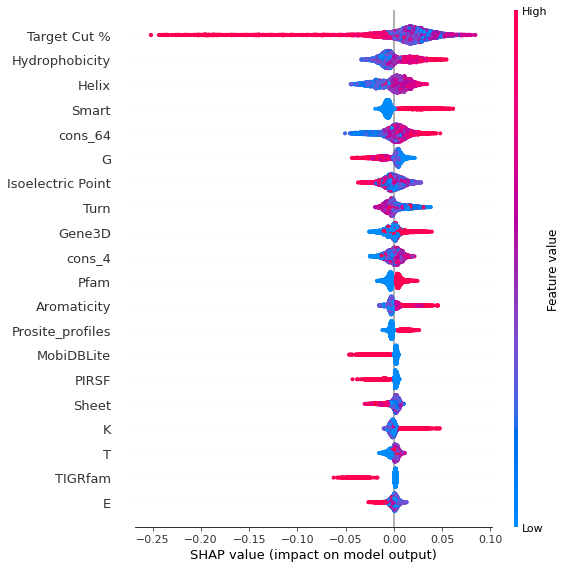

In [15]:
shap.summary_plot(shap_values, X_train_imputed)

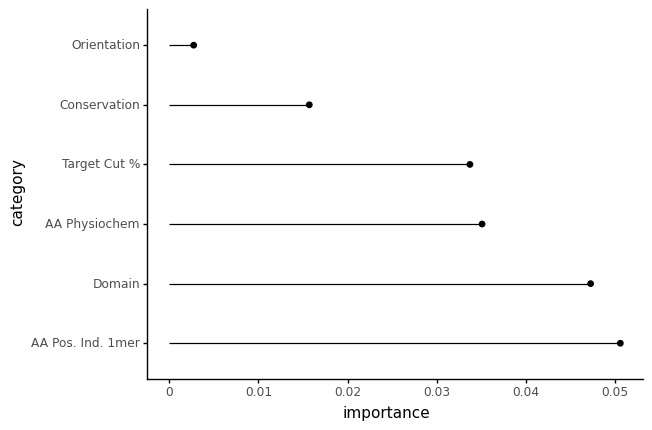

<ggplot: (8764073704837)>

In [16]:
feature_category_map = {'Target Cut %': 'Target Cut %',
                         'Orientation': 'sense',
                         'Domain': ['Pfam', 'PANTHER', 'HAMAP', 'SuperFamily', 'TIGRfam', 'ncoils', 'Gene3D',
                                    'Prosite_patterns', 'Seg', 'SignalP', 'TMHMM', 'MobiDBLite',
                                    'PIRSF', 'PRINTS', 'Smart', 'Prosite_profiles'],
                         'AA Physiochem': ['Gravy', 'Aromaticity',
                                           'Isoelectric Point', 'Helix', 'Turn', 'Sheet'],
                         'AA Pos. Ind. 1mer': '[A-Z]|\*',
                         'AA Pos. Ind. 2mer': '([A-Z]|\*){2}',
                         'AA Pos. Dep. 1mer': '\-?[0-9]([A-Z]|\*)',
                         'Conservation': ['cons_64', 'cons_4']}

shap_df = pd.DataFrame(shap_values, columns=X_train_imputed.columns)

feature_category_list = []
for category, feature in feature_category_map.items():
    if type(feature) == str:
        matched_cols = shap_df.columns.str.fullmatch(feature)
    else: # list
        matched_cols = shap_df.columns.isin(feature)
    category_features = shap_df.columns[matched_cols]
    feature_category_list.extend([{'feature': f, 'category': category} for f in category_features])
feature_category_df = pd.DataFrame(feature_category_list)
shap_abs_importance = (shap_df.abs().mean(0)
                       .reset_index()
                       .rename({0: 'importance',
                                'index': 'feature'}, axis=1)
                       .sort_values('importance', ascending=False)
                       .merge(feature_category_df, how='inner', on='feature'))
category_importance = (shap_abs_importance.groupby('category')
                       .agg({'importance': 'sum'})
                       .reset_index()
                       .sort_values('importance', ascending=False))
category_importance['category'] = pd.Categorical(category_importance['category'],
                                                 categories=category_importance['category'])

lolliplop_plot(category_importance, 'category', 'importance')


<ipython-input-17-0a48615a74e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


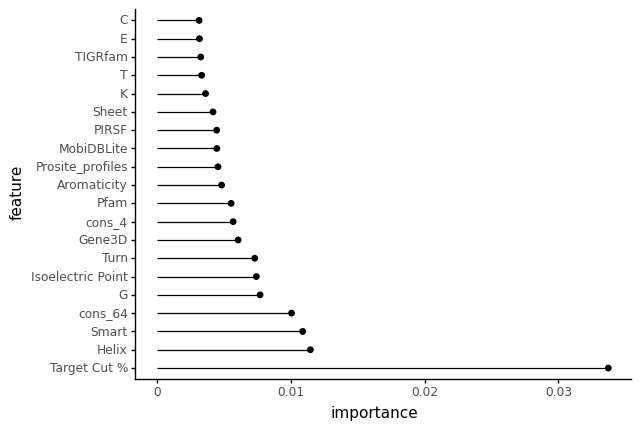

<ggplot: (8764073291484)>

In [17]:
top_n = 20
top_features = shap_abs_importance.head(top_n)
top_features['feature'] = pd.Categorical(top_features['feature'], categories=top_features['feature'])
lolliplop_plot(top_features, 'feature', 'importance')

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/plots/_scatter.py:642: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/shap/pl

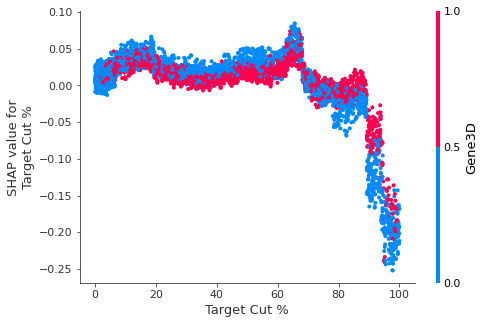

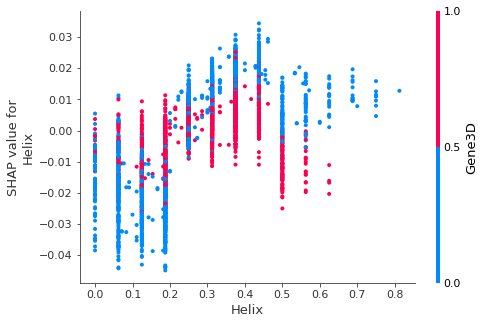

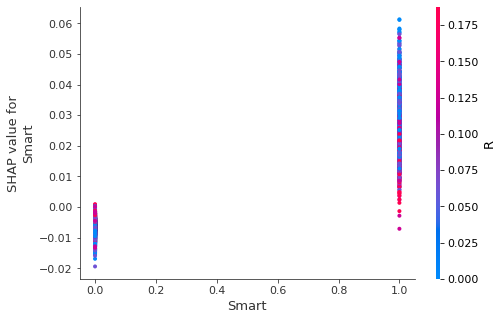

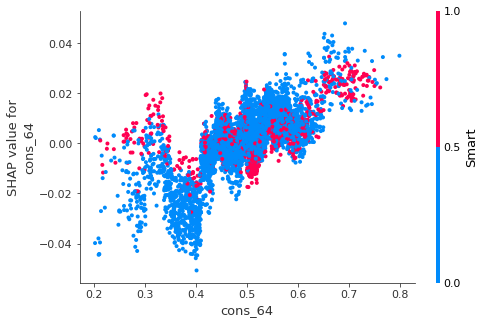

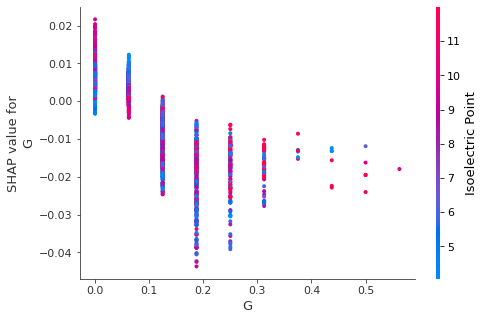

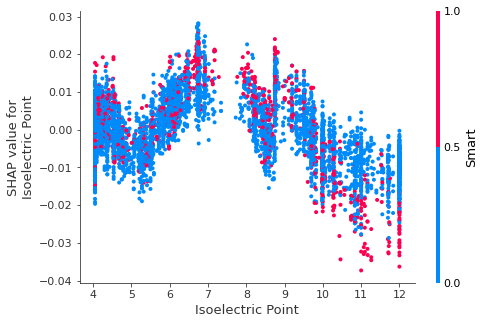

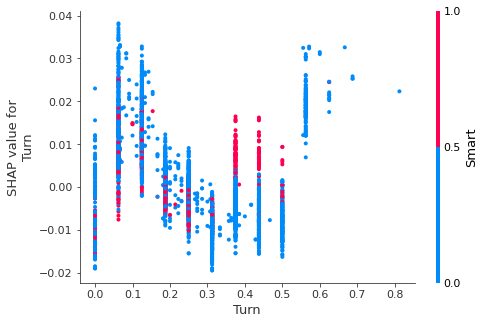

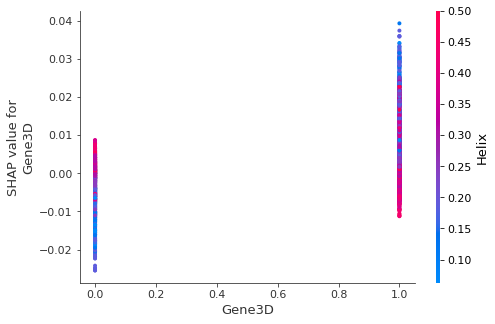

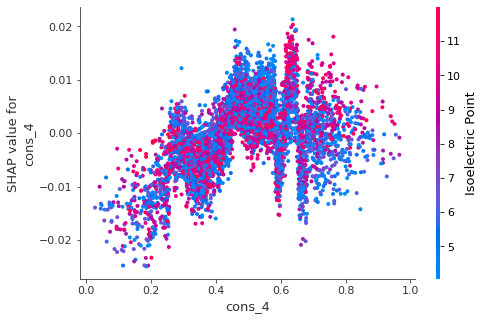

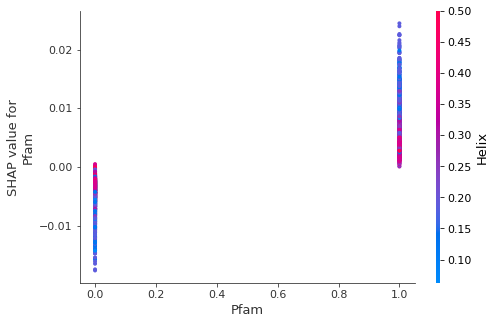

In [18]:
for feature in shap_abs_importance.head(10)['feature']:
    shap.dependence_plot(feature, shap_values, X_train_imputed)


## Depedence on G content

Due to the model's ability to pick out G content as a salient feature in residuals, we will retrain our
model supplying nucleotide information in additon to information about the protein target.

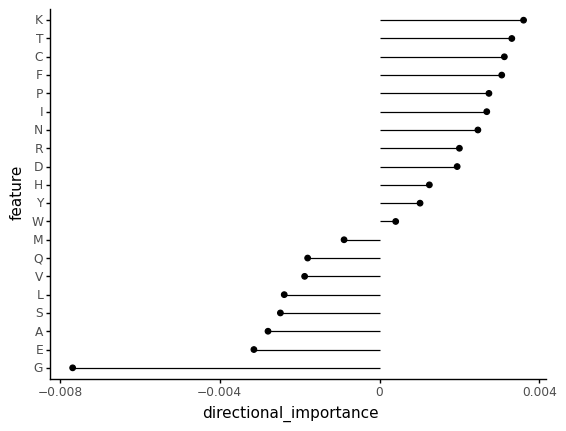

<ggplot: (8764073476325)>

In [19]:
def get_shap_correlation(df):
    if (df['importance'].std() > 0) and (df['value'].std() > 0):
        return stats.pearsonr(df['importance'], df['value'])[0]
    else:
        return pd.NA


long_shap_df = (shap_df.reset_index()
                .rename({'index': 'train_index'}, axis=1)
                .melt(id_vars='train_index', var_name='feature',
                      value_name='importance'))
long_train_df = (X_train_imputed.reset_index(drop=True)
                 .reset_index()
                 .rename({'index': 'train_index'}, axis=1)
                 .melt(id_vars='train_index', var_name='feature',
                       value_name='value'))
long_shap_train_values = (long_shap_df.merge(long_train_df, how='inner',
                                             on=['train_index', 'feature']))
nonzero_shap_train_values = long_shap_train_values[long_shap_train_values['importance'] != 0]
shap_correlations = (nonzero_shap_train_values.groupby('feature')
                     .apply(lambda df: get_shap_correlation(df))
                     .reset_index(name='pearson_r'))
shap_correlations['direction'] = np.sign(shap_correlations['pearson_r'])
shap_directional_importance = (shap_abs_importance.merge(shap_correlations, how='inner',
                                                         on='feature'))
shap_directional_importance['directional_importance'] = (shap_directional_importance['direction'] *
                                                         shap_directional_importance['importance'])
shap_directional_importance = shap_directional_importance.sort_values('directional_importance')
aa_directional_importance = (shap_directional_importance[shap_directional_importance.category == 'AA Pos. Ind. 1mer']
                             .copy())
aa_directional_importance['feature'] = pd.Categorical(aa_directional_importance['feature'],
                                                      categories=aa_directional_importance['feature'])
lolliplop_plot(aa_directional_importance, 'feature', 'directional_importance')

In [20]:
aa_nt_frac = (codon_map_df.groupby('Amino Acid')
              .agg(joined_codons = ('Codon', ''.join))
              .reset_index())


In [21]:
for nt in ['A', 'C', 'T', 'G']:
    aa_nt_frac[nt + ' frac.'] = aa_nt_frac['joined_codons'].str.count(nt)/aa_nt_frac['joined_codons'].str.len()

In [22]:
def make_physiochem_df(physio_dict, name):
    df = (pd.DataFrame.from_dict(physio_dict, orient='index')
          .reset_index()
          .rename({'index': 'Amino Acid',
                   0: name}, axis=1))
    return df


hydrophobicity_df = make_physiochem_df(ProtParamData.kd, 'hydrophobicity')
hydrophilicity_df = make_physiochem_df(ProtParamData.hw, 'hydrophilicity')
sa_df = make_physiochem_df(ProtParamData.em, 'surface accessibility')
ste_df = make_physiochem_df(ProtParamData.ja, 'surface transfer energy')
flex_df = make_physiochem_df(ProtParamData.Flex, 'flexibility')
all_physiochem_df = aa_nt_frac
for df in [hydrophobicity_df, hydrophilicity_df, sa_df, ste_df, flex_df]:
    all_physiochem_df = all_physiochem_df.merge(df, how='inner', on='Amino Acid')
all_physiochem_df = all_physiochem_df.merge(aa_directional_importance[['feature',
                                                                       'directional_importance']], how='left',
                                            left_on='Amino Acid', right_on='feature')
importance_cor = all_physiochem_df.corr().loc[:,'directional_importance']
importance_cor.sort_values()

G frac.                   -0.591394
surface transfer energy   -0.223262
hydrophobicity            -0.126597
flexibility               -0.125456
hydrophilicity             0.018044
C frac.                    0.161527
T frac.                    0.185424
surface accessibility      0.207054
A frac.                    0.267709
directional_importance     1.000000
Name: directional_importance, dtype: float64

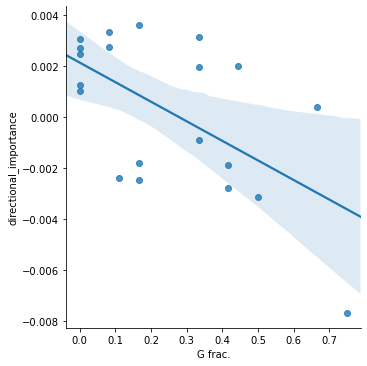

In [23]:
sns.lmplot(data=all_physiochem_df, x='G frac.', y='directional_importance',
           truncate=False)

In [24]:
exog_endog_df = (sg_groups_df.merge(exog_df.assign(sgRNA_Activity_Exog = exog_df['sgRNA Activity'].rank(pct=True)),
                                    how='inner',
                                    on=['sgRNA Sequence',
                                        'sgRNA Context Sequence',
                                        'PAM Sequence'],
                                    suffixes=(' Endog', ' Exog')))
(exog_endog_df.groupby('sgRNA Target')
 .filter(lambda df: df.shape[0] > 1)
 .groupby('sgRNA Target')
 .apply(lambda df: stats.pearsonr(df['sgRNA Activity Endog'],
                                  df['sgRNA_Activity_Exog'])))

sgRNA Target
ANPEP        (0.741289936990902, 8.727414433646684e-68)
CD33      (0.41428818900460146, 3.7788986790904215e-06)
CUL3        (0.5325726695230142, 6.391709235543067e-10)
Cd28        (0.5677528214431656, 2.737718315079288e-06)
Cd5         (0.663211741483736, 2.3782223814125275e-27)
FUT4         (0.6753722476303079, 8.67565027149022e-33)
H2-K1      (0.5592901605373098, 2.7952311171969454e-06)
HPRT1       (0.7524699816782086, 8.204721947320048e-11)
MED12      (0.4747435357605045, 1.1908200999997973e-45)
NF1       (0.43238500830246795, 2.5477137981291034e-28)
NF2        (0.3174923053121345, 1.1257810306941096e-05)
Ptprc        (0.639197394186708, 3.989134548944602e-27)
SGF29       (0.5399762151009133, 5.644843303175953e-10)
Spn         (0.6393076154347874, 2.523203457856921e-14)
TADA1       (0.5547780868810852, 9.560222860910947e-09)
TADA2B      (0.539804806953084, 2.4992025581765925e-13)
Thy1        (0.5811822897360835, 7.755410726109264e-06)
dtype: object

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.


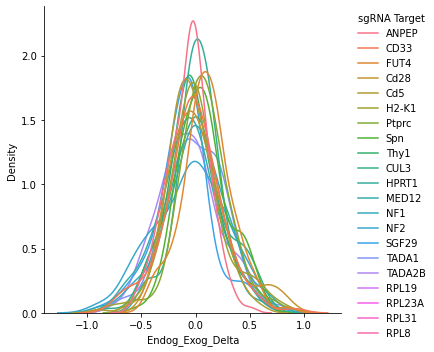

In [25]:
exog_endog_df['Endog_Exog_Delta'] = exog_endog_df['sgRNA Activity Endog'] - exog_endog_df['sgRNA_Activity_Exog']
sns.displot(data=exog_endog_df, x='Endog_Exog_Delta', kind='kde', hue='sgRNA Target',
            common_norm=False)

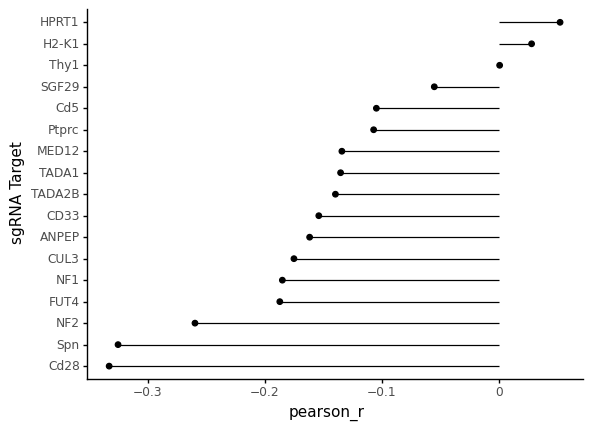

<ggplot: (8764075933949)>

In [26]:
exog_endog_df['G content'] = exog_endog_df['sgRNA Context Sequence'].str.count('G')
G_content_correlation = (exog_endog_df.groupby('sgRNA Target')
                         .filter(lambda df: df.shape[0] > 1)
                         .groupby('sgRNA Target')
                         .apply(lambda df: stats.pearsonr(df['Endog_Exog_Delta'],
                                                          df['G content'])[0])
                         .reset_index(name='pearson_r')
                         .sort_values('pearson_r'))
G_content_correlation['sgRNA Target'] = pd.Categorical(G_content_correlation['sgRNA Target'],
                                                       categories=G_content_correlation['sgRNA Target'])
lolliplop_plot(G_content_correlation, 'sgRNA Target', 'pearson_r')


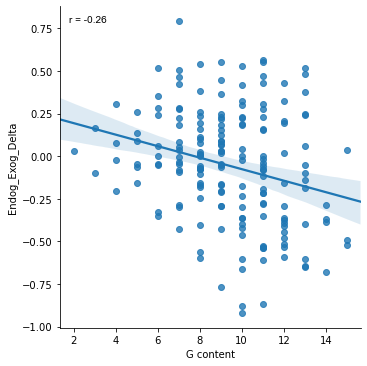

In [27]:
sns.lmplot(data=exog_endog_df[exog_endog_df['sgRNA Target'] == 'NF2'],
           x='G content',
           y='Endog_Exog_Delta',
           truncate=False)
gpplot.add_correlation(data=exog_endog_df[exog_endog_df['sgRNA Target'] == 'NF2'],
                       x='G content',
                       y='Endog_Exog_Delta')
sns.despine()
